# Accuracy Comparison

In [218]:
# Standard packages
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
import statistics

# Local packages
from simulate import *

In [250]:
# Load data. Less than 2 MiB.
# Data aggregated over 5 runs, up to 100ms of simulation
with open('polybench-subset-mf.pkl', 'rb') as file:
    mf = pickle.load(file)
with open('polybench-subset-mf-newparams.pkl', 'rb') as file:
    mf_n = pickle.load(file)
with open('polybench-subset-normal.pkl', 'rb') as file:
    norm = pickle.load(file)

In [224]:
mf.st['2mm'].ipc[0]

0.6305195831525979

In [251]:
names = list(mf.st.keys())
y_norm_ipc  = [norm.st[n].ipc[0] for n in names]
y_mf_ipc    = [mf.st[n].ipc[0]   for n in names]
y_mfn_ipc   = [mf_n.st[n].ipc[0]   for n in names]

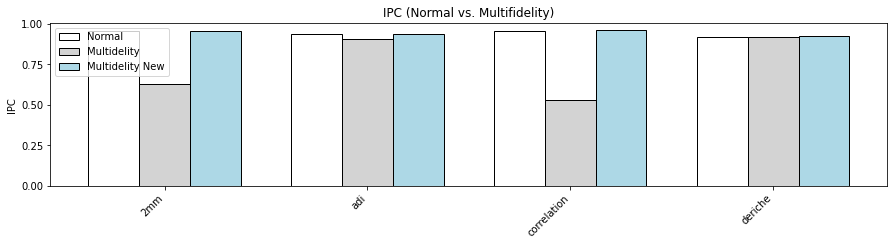

In [256]:
x = np.arange(len(names))
width = 0.25
fig, ax = plt.subplots()
ax.bar(x-width, y_norm_ipc, width, color='white', label='Normal', edgecolor='black')
ax.bar(x, y_mf_ipc, width, color='lightgrey', label='Multidelity', edgecolor='black')
ax.bar(x+width, y_mfn_ipc, width, color='lightblue', label='Multidelity New', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylim((0,1))
ax.set_ylabel('IPC', rotation=90)
ax.set_title('IPC (Normal vs. Multifidelity)')
ax.autoscale()
plt.legend()

#ax.yaxis.set_label_coords(-.07, 0.96)
nyticks = 5
ax.set_yticks([(1/(nyticks-1))*x for x in np.arange(nyticks)])
fig.set_size_inches((15,3))
fig.savefig('plots/ipc-normal-vs-mf.png')
#plt.tight_layout()

In [253]:
pct_err = []

def p_err(approx, exact):
    return (approx-exact)/exact * 100
def mape(arr):
    return np.mean(np.absolute(arr))

print('Percent error\n')
name_len = max([len(name) for name in names])
for (i, name) in enumerate(names):
    pe = p_err(y_mf_ipc[i], y_norm_ipc[i])
    pct_err.append(pe)
    print(f'{i}'.ljust(2), f'{name}'.ljust(name_len), f'{pe: 06.2f}%')
    
print(f'\nMAPE: {mape(pct_err):.2f}%')

Percent error

0  2mm         -33.82%
1  adi         -03.32%
2  correlation -44.52%
3  deriche      00.43%

MAPE: 20.52%


In [254]:
# Speed up calculations
mf_times_seconds = []
norm_times_seconds = []
for name in names:
    mf_times_seconds.append(mf_n.st[name].times.real.mean/nu.s)
    norm_times_seconds.append(norm.st[name].times.real.mean/nu.s)

speedup_pct = [((norm_times_seconds[i] / mf_times_seconds[i])-1)*100 for i in range(len(names))]

print('Percent speedup\n')
for i in range(len(names)):
    print(f'{i}'.ljust(2), f'{names[i]}'.ljust(name_len), f'{speedup_pct[i]: 7.2f}%')

print(f'\nAverage percent speedup: {np.mean(speedup_pct):.2f}%')

Percent speedup

0  2mm           -0.58%
1  adi           -2.03%
2  correlation   -1.74%
3  deriche       -0.35%

Average percent speedup: -1.17%


In [234]:
# Calculate speedup of the Memory simulation (subtract off Ariel time)

def mean_ariel_time(data, name):
    return np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in data.st[name].profile])

mf_times_seconds_noariel = []
norm_times_seconds_noariel = []
for name in names:
    mf_times_seconds_noariel.append(mf.st[name].times.real.mean/nu.s - mean_ariel_time(mf,name))
    norm_times_seconds_noariel.append(norm.st[name].times.real.mean/nu.s - mean_ariel_time(norm,name))

In [235]:
ariel_time = np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile])
ariel_time

833.451725

In [249]:
print('Percent speedup without Ariel')
#TODO - also remove parrot time from norm runs

speedup_pct = [((norm_times_seconds_noariel[i] / mf_times_seconds_noariel[i])-1)*100 for i in range(len(names))]

for i, n in enumerate(names):
    print(f'{n.ljust(14)}: {speedup_pct[i]:6.02f}%')

Percent speedup without Ariel
2mm           : 244.29%
adi           :   1.64%
correlation   : 297.60%
deriche       :  10.69%


In [196]:
norm.st['deriche']

Profiler: ClockStats
                         Name      count   handler time (s)  \
0                 ariel.ariel  199999999            254.418   
1            memHierarchy.Bus   24576113             13.962   
2          memHierarchy.Cache  155077942            331.588   
3  memHierarchy.MemController   49999999            102.050   
4         memHierarchy.Parrot   78646625             68.045   

    avg. handler time (ns)  
0                     1272  
1                      568  
2                     2138  
3                     2041  
4                      865  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus      4725089           0.436                    92
1  memHierarchy.MemLink    105901573         250.344                  2363
2   memHierarchy.Parrot    100380124          42.935                   427
Simulated time:
  2.37 (+/-0.16) ms
Wallclock Time:
  Real: 30206.85 (+/-476.47) ms
  User: 29819.93 (+/-

In [197]:
[np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile]

[477.159364, 478.199233, 472.19425700000005, 458.189289, 468.041158]